# 6 CNN

## 6.2 图像卷积


### 6.2.1 互相关运算
在卷积层中，输入张量和核张量通过互相关运算产生输出张量。
因为要足够的空间在图像上“移动卷积核，可以通过在图像边界周围填充0来保证有足够的空间移动内核。从而保持输出大小不变

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

def corr2d(X, K):
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    
    return Y
    

In [2]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

### 6.2.2卷积层
基于上面定义的corr2d函数实现二维卷积层。在__init__构造函数中，将weight和bias声明为两个模型参数，前向传播函数调用corr2d函数并添加偏置

In [3]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeors(1))
        
    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

### 6.2.3 图像中目标的边缘检测


In [4]:
X = torch.ones((6, 8))
X[:, 2: 6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

构造一个可以检测垂直边缘的卷积核

In [5]:
K = torch.Tensor([[1.0, -1.0]])
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

对水平边缘的检测就不太行

In [6]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

### 6.2.4 学习卷积核


In [7]:
conv2d = nn.Conv2d(1, 1, kernel_size=(1, 2), bias=False)

#这个二维卷积层使用四维输入和输出格式（批量大小，通道，高度，宽度）
#其中批量大小和通道数都是1

X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))

for i in range(100):
    Y_hat = conv2d(X)
    l = (Y_hat - Y)  ** 2
    conv2d.zero_grad()
    l.sum().backward()
    conv2d.weight.data[:] -= 0.003 * conv2d.weight.grad
    print(f'batch {i+1}, loss {l.sum():.3f}')

batch 1, loss 5.794
batch 2, loss 5.279
batch 3, loss 4.834
batch 4, loss 4.445
batch 5, loss 4.098
batch 6, loss 3.787
batch 7, loss 3.505
batch 8, loss 3.247
batch 9, loss 3.011
batch 10, loss 2.794
batch 11, loss 2.593
batch 12, loss 2.408
batch 13, loss 2.236
batch 14, loss 2.077
batch 15, loss 1.930
batch 16, loss 1.793
batch 17, loss 1.666
batch 18, loss 1.548
batch 19, loss 1.438
batch 20, loss 1.336
batch 21, loss 1.242
batch 22, loss 1.154
batch 23, loss 1.072
batch 24, loss 0.997
batch 25, loss 0.926
batch 26, loss 0.861
batch 27, loss 0.800
batch 28, loss 0.743
batch 29, loss 0.691
batch 30, loss 0.642
batch 31, loss 0.596
batch 32, loss 0.554
batch 33, loss 0.515
batch 34, loss 0.479
batch 35, loss 0.445
batch 36, loss 0.413
batch 37, loss 0.384
batch 38, loss 0.357
batch 39, loss 0.332
batch 40, loss 0.308
batch 41, loss 0.287
batch 42, loss 0.266
batch 43, loss 0.247
batch 44, loss 0.230
batch 45, loss 0.214
batch 46, loss 0.199
batch 47, loss 0.185
batch 48, loss 0.171
b

In [8]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 0.9829, -0.9829]])

In [9]:
conv2d(X)

tensor([[[[ 0.0000,  0.9829,  0.0000,  0.0000,  0.0000, -0.9829,  0.0000],
          [ 0.0000,  0.9829,  0.0000,  0.0000,  0.0000, -0.9829,  0.0000],
          [ 0.0000,  0.9829,  0.0000,  0.0000,  0.0000, -0.9829,  0.0000],
          [ 0.0000,  0.9829,  0.0000,  0.0000,  0.0000, -0.9829,  0.0000],
          [ 0.0000,  0.9829,  0.0000,  0.0000,  0.0000, -0.9829,  0.0000],
          [ 0.0000,  0.9829,  0.0000,  0.0000,  0.0000, -0.9829,  0.0000]]]],
       grad_fn=<ThnnConv2DBackward>)

## 6.3 填充和步幅
- 填充可以解决输入和输出大小不一致的问题
- 步幅可以解决输入的分辨率冗余的问题

### 6.3.1 填充
一般卷积核大小kxk都是奇数，这样可以：
- 所有边的填充行数(k - 1) / 2 都相同
- 输入和输出具有相同的高度和宽度

In [10]:
import torch
from torch import nn

#这个函数初始化卷积层权重，对输入和输入提高和缩减相应的维数
def comp_conv2d(conv2d, X):
    #这里的(1, 1)表示批量大小和通道数都是1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    #省略前两个维度：批量大小和通道
    return Y.reshape(Y.shape[2:])

conv2d = nn.Conv2d(1, 1 ,kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

当卷积内核的高度和宽度不同的时候，可以填充不同的高度、宽度，让输入输出的size相同

In [11]:
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

### 6.3.2 步幅
之前默认每次卷积都滑动1个窗口，为了减小输出的冗余，可以设置水平、竖直步幅。
注意如果数据大小不足以让卷积核继续按照步幅滑动，则不计算剩下的数据。即计算输出大小的时候是向下取整

将高度和宽度的步幅设置为2，从而将输入的高度和宽度减半

In [12]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [13]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

## 6.4 多输入多输出通道
每个RGB图像具有3 x h x W的形状。这个大小为3的轴被称为通道（channel）维度

### 6.4.1 多输入通道
如果输入包含多个通道，需要构造一个与输入数据具有相同输入通道数目的卷积核，以便与输入数据进行互相关运算。
输出的结果是每个通道对应位置之和

In [14]:
import torch

#这里匿名函数传入三个参数，x，可变参数*args 作为tuple传进， **kwargs作为dict传入，这里后面两个参数没啥用
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)

def corr2d(X, K):
    #计算二维互相关运算
    #print(X.shape, K.shape)
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = reduce_sum(X[i:i+h, j:j+w] * K)
            #print(X[i:i+h, j:j+w] * K)  
    return Y

def corr2d_multi_in(X, K):
    # 先遍历 “X” 和 “K” 的第0个维度（通道维度），再把它们加在一起
    return sum(corr2d(x, k) for x, k in zip(X, K))

In [15]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

### 6.4.2 多输出通道
随着神经网络层数的增加，经常会增加输出通道的维数。可以将每个通道看做是对不同特征的相应，但是实际上每个通道不是独立的，是为了共同使用而优化的

计算一个多通道的互相关函数

In [16]:
#stack 是沿着一个新的维度对输入张量序列进行连接。序列中的所有张量都应该是相同的形状
x1 = torch.arange(4).reshape(2, 2)
x2 = torch.arange(4, 8).reshape(2, 2)
torch.stack([x1, x2], 0)

tensor([[[0, 1],
         [2, 3]],

        [[4, 5],
         [6, 7]]])

In [17]:
def corr2d_multi_in_out(X, K):
    # 迭代“K”的第0个维度，每次都对输入“X”执行互相关运算。
    # 最后将所有结果都叠加在一起
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

构造一个有三个通道的卷积核

In [18]:
K = torch.stack((K, K + 1, K + 2), dim=0)
K.shape

torch.Size([3, 2, 2, 2])

In [19]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

### 6.4.3 1X1 卷积层
1x1的卷积实际上就是给输入中的每个图像进行全连接层，没有起到卷积的互相关运算作用
1×1 卷积层通常用于调整网络层的通道数量和控制模型复杂性。

In [20]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape(c_i, h * w)
    K = K.reshape(c_o, c_i)
    #全连接层中的矩阵乘法
    Y = torch.matmul(K, X)
    return  Y.reshape((c_o, h, w))

当执行 1×1 卷积运算时，上述函数相当于先前实现的互相关函数corr2d_multi_in_out

In [21]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

## 6.5 Pooling
Pooling的目的：
- 降低卷积层对位置的敏感性
- 同时降低对空间降采样表示的敏感性

### 6.5.1 最大汇聚层和平均汇聚层

In [22]:
import torch
from torch import nn
from d2l import torch as d2l

def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = torch.max(X[i: i + p_h, j: j + p_w])
            elif mode == 'avg':
                Y[i, j] = torch.mean(X[i: i + p_h, j: j + p_w])
    
    return Y

In [23]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [24]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

### 6.5.2 填充和步幅
和卷积层一样，汇聚层也可以改变输出形状。可以通过填充和步幅以获得所需的输出形状


构造一个输入张量X，它有四个维度，其中样本数和通道数都是1

In [26]:
X = torch.arange(16, dtype=torch.float32).reshape(1, 1, 4, 4)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

默认情况下，深度学习框架中的步幅与汇聚窗口的大小相同。因此，如果使用形状为(3, 3)的汇聚窗口，那么默认情况下，我们得到的步幅形状为(3, 3)

In [28]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

C:\Users\ADRIN\Anaconda3\envs\torch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([[[[10.]]]])

填充和步幅也可以手动设置

In [30]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d

MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

也可以设定一个任意大小的矩形汇聚窗口，并且分别设定填充和步幅的高度和宽度。

In [31]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

## 6.6 卷积神经网络(LeNet)
之前通过将mnist28x28的图像展平成784的一维向量进行softmax的学习，通过卷积运算不用展平，需要的参数更少，就可以达到分类的效果

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

In [4]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


### 6.6.2 训练模型

Accumulator：记录各种训练参数的类

In [11]:
class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n#一个长度为n的list
        
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        
    def reset(self):
        self.data = [0.0] * len(self.data)
    
    def  __getitem__(self, idx):
        return self.data[idx]

In [10]:
metric = Accumulator(2)
metric.add(0.1, 0.1)
metric.data

[0.1, 0.1]

计算预测正确的数量

In [12]:
argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
#argmax 表示寻找向量所在的最大值的下标
#axis = 1表示查找每一行中最大的（按照列查找）

def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = argmax(y_hat, axis=1)
    cmp = d2l.astype(y_hat, y.dtype) == y
    return float(d2l.reduce_sum(d2l.astype(cmp, y.dtype)))

In [14]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [25]:
y = torch.randint(0, 10, (4, 4))
y, y.argmax(axis=1), y.argmax(axis=0)

(tensor([[4, 5, 5, 6],
         [3, 2, 0, 6],
         [1, 2, 7, 7],
         [3, 2, 8, 1]]),
 tensor([3, 3, 2, 2]),
 tensor([0, 0, 3, 2]))

In [26]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()#设置为评估模式
        #只有在模型中有Dropout和BatchNorm的时候才会有影响
        if not device:
            device = next(iter(net.parameters())).device
    #记录正确预测的数量，总预测的数量
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
            #numel() 返回数组中元素的个数
        return metric[0] / metric[1]

In [27]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，范例数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.465, train acc 0.827, test acc 0.810
6639.5 examples/sec on cpu


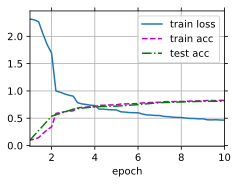

In [28]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [30]:
torch.cuda.device_count()

0

In [31]:
nvidia-smi

NameError: name 'nvidia' is not defined